In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
import dataset as ds
from matplotlib.patches import Patch

In [2]:
#os.listdir("./DFC_Public_Dataset_ORIGINAL/ROIs0000_autumn/dfc_BandarAnzali")

In [2]:
path = "./data"
ds = ds.DFC20(path, subset="val", use_s1=False, use_s2_RGB=True, use_s2_hr=False, use_s2_all=False)

[Load]: 100%|██████████| 684/684 [00:00<00:00, 97761.33it/s]

loaded 684 samples from the DFC20 subset val


3
ROIs0000_winter_s2_KippaRing_p488.tif


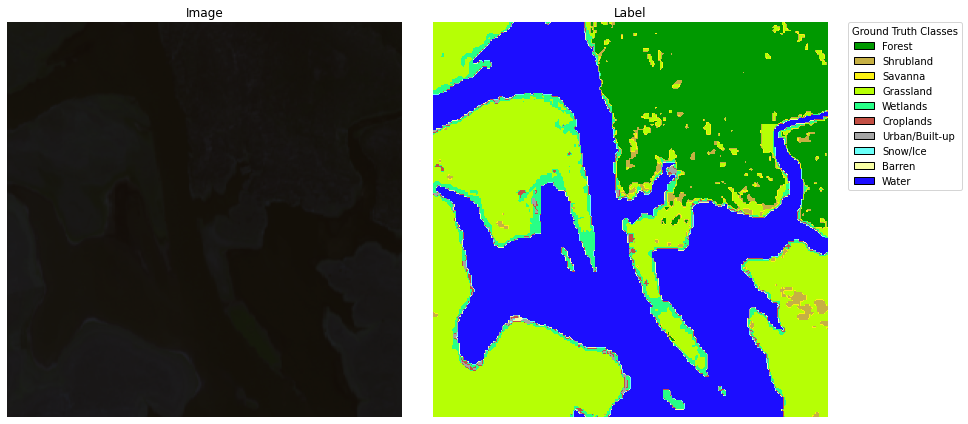

In [4]:
patch = ds.__getitem__(402)
print(len(patch))
print(patch["id"])
visualize_rgb_dfc(patch)

In [3]:
def visualize_rgb_dfc(patch):
    # Class names and colors from your table
    class_info = ds.class_info

    # Prepare the image (transpose if needed)
    image = patch['image']
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))

    # Create a figure with two subplots and space for a legend
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Wider figure to accommodate legend

    # Plot the image
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')

    # Create a custom colormap for the labels
    from matplotlib.colors import ListedColormap
    colors = [color for _, color in class_info.values()]
    cmap = ListedColormap(colors)

    # Plot the label with the custom colormap
    label = patch['label']
    im = ax[1].imshow(label, cmap=cmap, vmin=1, vmax=len(class_info))
    ax[1].set_title('Label')
    ax[1].axis('off')

    # Create a legend for the classes
    legend_elements = [
        Patch(facecolor=color, edgecolor='black', label=name) 
        for name, color in class_info.values()
    ]
    plt.legend(
        handles=legend_elements,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        title="Ground Truth Classes"
    )

    plt.tight_layout()
    plt.show()


RANDOM PLOT LIB PATH

In [83]:
# Load the TIFF mask
#path = os.getcwd()
path = "./DFC_Public_Dataset_ORIGINAL/ROIs0000_autumn/dfc_BandarAnzali/ROIs0000_autumn_dfc_BandarAnzali_p130.tif"
path = "./DFC_Public_Dataset_ORIGINAL/ROIs0000_winter/dfc_KippaRing/ROIs0000_winter_dfc_KippaRing_p170.tif"

#path = "./DFC_Public_Dataset_ORIGINAL/ROIs0000_autumn/s2_BandarAnzali/ROIs0000_autumn_s2_BandarAnzali_p510.tif"
#path = "./DFC_Public_Dataset_ORIGINAL/ROIs0000_autumn/lc_BandarAnzali/ROIs0000_autumn_lc_BandarAnzali_p510.tif"
#with rasterio.open(mask_path) as src:
#    mask = src.read(1)  # Read the first (or only) band
img = rasterio.open(path).read(1)

unique_values = np.unique(img)
print("Unique values in the mask:", unique_values)

print("Shape:", img.shape)

Unique values in the mask: [ 1  2  4  5  6  7  9 10]
Shape: (256, 256)


In [61]:
def visualize_tiff(image_path):
    with rasterio.open(image_path) as src:
        img = src.read()

        # Check the number of bands
        num_bands = img.shape[0]

        if num_bands > 3:  # At least 3 bands for RGB visualization#
            print("Shape:", img.shape)

            rgb_indices = [3, 2, 1] if num_bands > 3 else [0, 1, 2]

            # Extract RGB channels and stack them into a single array with shape (height, width, 3)
            img_rgb = np.stack([img[rgb_indices[0]], img[rgb_indices[1]], img[rgb_indices[2]]], axis=-1)

            print("Shape:", img_rgb.shape)
            
            # Normalize the image
            #img_rgb = np.clip(img_rgb / np.max(img_rgb), 0, 1)
            
            #or
            #img_rgb = img_rgb.astype(np.float32)
            #img_rgb = np.clip(img_rgb, 0, 10000)
            #img_rgb /= 10000
            #img_rgb = img_rgb.astype(np.float32)

            # Normalize the image for each channel using the calculated mean and std
            # Broadcasting: mean and std should have shape (1, 1, 3)
            print("Before standardization: min =", img_rgb.min(), "max =", img_rgb.max())
            #img_rgb = (img_rgb - mean[None, None, :]) / (std[None, None, :] + 1e-5)  # Avoid division by zero
            img_rgb = (img_rgb - mean[::-1][None, None, :]) / (std[::-1][None, None, :] + 1e-5)
            print("After standardization: min =", img_rgb.min(), "max =", img_rgb.max())
            #print(mean)
            #print(std)
            # Convert from standardized range (~[-2, 2]) to [0,1] for display
            img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())
            
            # Example: Applying contrast stretching
            #img_rgb = img_rgb.astype(np.float32)
            #p2, p98 = np.percentile(img_rgb, (2, 98))  # Get 2nd and 98th percentile
            #img_rgb = np.clip((img_rgb - p2) / (p98 - p2), 0, 1)  # Scale to [0,1]
            
            

            plt.figure(figsize=(10, 10))
            plt.imshow(img_rgb)
            plt.axis("off")
            plt.title("TIFF Image Visualization")
            plt.show()
        else:
            # Show single-band image (grayscale)
            plt.figure(figsize=(10, 10))
            plt.imshow(img[0], cmap="gray")
            plt.axis("off")
            plt.title("Single-Band TIFF Image")
            plt.show()

# Example usage


Shape: (13, 256, 256)
Shape: (256, 256, 3)
Before standardization: min = 437 max = 1678
After standardization: min = -0.7825701657273388 max = 2.9690364505586713


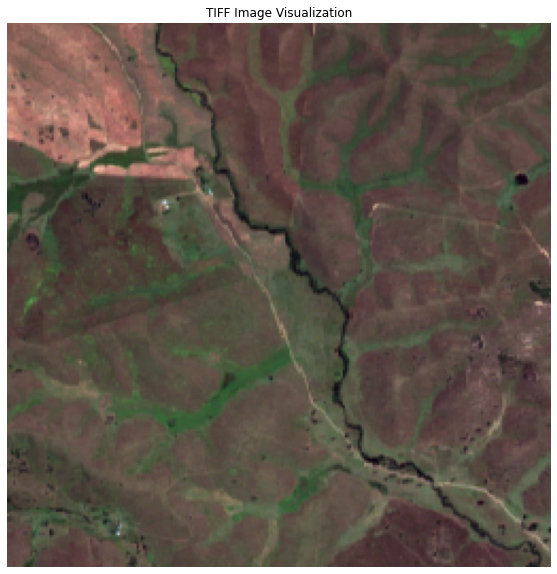

In [63]:
#path = "./data/train/s2/ROIs0000_test_s2_0_p6.tif"
path = "./DFC_Public_Dataset_ORIGINAL/ROIs0000_autumn/s2_BandarAnzali/ROIs0000_autumn_s2_BandarAnzali_p398.tif"
#path = "./DFC_Public_Dataset_ORIGINAL/ROIs0000_autumn/s2_CapeTown/ROIs0000_autumn_s2_CapeTown_p702.tif"'
path = "./DFC_Public_Dataset_ORIGINAL/ROIs0000_winter/s2_KippaRing/ROIs0000_winter_s2_KippaRing_p110.tif"

visualize_tiff(path)

SINGLE BAND VISULAIZE

(10.0, 10.0)
(256, 256)


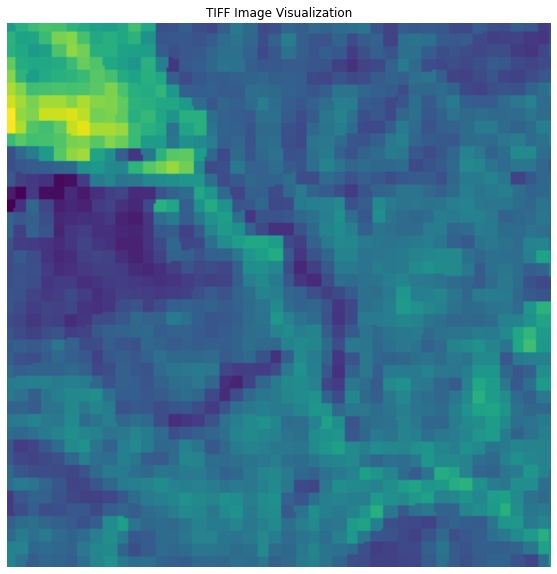

In [67]:
with rasterio.open(path) as src:
    print(src.res)
    img = src.read(1)
    print(img.shape)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title("TIFF Image Visualization")
    plt.show()